In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

---
# 1. 사진 준비
---

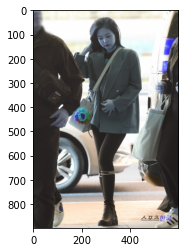

(899, 600, 3)


In [70]:
import os

# 멀리서 보이는 제니 전신샷을 들고 왔다.
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/jenny_faraway.jpg'
img_bgr = cv2.imread(my_image_path) # open cv로 읽고
# img_bgr = cv2.resize(img_bgr, (1350*2, 1080*3)) # resize하면 찌그러져서 안했다.
img_show = img_bgr.copy() # 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()
print(img_bgr.shape)

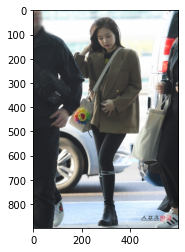

In [54]:
# bgr 에서 rgb로 바꿔서 푸르딩딩한 사진을 바꾸자
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

---
# 2. Face detection
dlib의 face detector는 HOG(Histogram of oriented Gradient) feature를 이용해서 svm의 sliding window로 얼굴을 찾는다.

---

In [55]:
import dlib
detector_hog = dlib.get_frontal_face_detector() # detector선언
print('--')

--


In [56]:
# bounding box
import cv2
dlib_rects=detector_hog(img_rgb,1)
print('--')

--


## 이미지 피라미드 
* detector_hog의 두번째 파라미터가 이미지 피라미드
* 동일 이미지의 서로 다른 사이즈의 세트
* 업샘플링으로 크기를 키우는 것
* 이미지 피라미드에서 얼굴 검출시 작게 촬영된 얼굴을 크게 볼 수 있어 더 정확한 검출이 가능

In [57]:
print(dlib_rects) #얼굴영역 좌표

rectangles[[(262, 88) (337, 163)]]


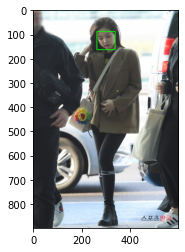

In [58]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()    
    r = dlib_rect.right()    
    b = dlib_rect.bottom()    
    cv2.rectangle(img_show,(l,t),(r,b),(0,255,0),2,lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)    
plt.imshow(img_show_rgb)
plt.show()
# 이쁘게 네모 박스로 얼굴이 잡혔다.

---
# 3. Face landmark
---

In [59]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print('--')

--


In [60]:
list_landmarks=[]
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb,dlib_rect) # dlib.full_object_detection 반환
    list_points=list(map(lambda p:(p.x,p.y),points.parts()))
    list_landmarks.append(list_points)
print(len(list_landmarks[0])) #68개의 랜드마크가 얼굴 개수만큼 저장됨
print(list_landmarks[0][0])
print(list_landmarks)


68
(266, 119)
[[(266, 119), (269, 127), (273, 134), (277, 141), (282, 148), (289, 153), (296, 157), (304, 161), (311, 161), (319, 158), (325, 153), (331, 145), (335, 137), (338, 128), (338, 118), (336, 107), (334, 97), (265, 111), (268, 107), (273, 106), (279, 106), (285, 107), (295, 103), (300, 99), (307, 95), (314, 93), (321, 95), (292, 114), (294, 120), (295, 125), (297, 131), (293, 136), (296, 137), (300, 137), (303, 135), (306, 133), (273, 119), (276, 118), (280, 117), (286, 118), (281, 120), (277, 121), (303, 113), (306, 110), (311, 109), (316, 108), (312, 111), (308, 113), (294, 147), (297, 144), (299, 142), (302, 142), (305, 141), (309, 141), (315, 142), (311, 147), (308, 150), (305, 151), (302, 151), (298, 150), (296, 147), (300, 146), (303, 145), (305, 144), (313, 142), (306, 145), (303, 146), (301, 146)]]


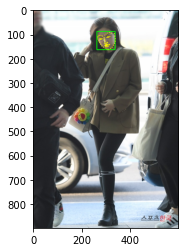

In [61]:
# 랜드마크 영상에 출력하기
for landmark in list_landmarks:
    for idx,point in enumerate(list_points):
        cv2.circle(img_show,point,2,(0,255,255),-1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
# 너무 작아서 안보이는데 랜드마크 잡힌거 맞다.

---
# 4. 스티커 적용하기
---

1. landmark위치 
- landmark 위치 2,36,48,30번 인덱스 사용  

top-left 이미지 시작점 지정
- x: 30번 위치에서 - 수염 이미지의 가로 길이 절반 
- y: 30번 위치에서 - 수염 이미지의 세로 길이 절반

2. sticker크기  
length = dlib_rect.width()  
width = length  
height = length
그대로 적용

In [62]:
for dlib_rect,landmark in zip(dlib_rects,list_landmarks):
    print(landmark[30]) # nose center index :30
    x = landmark[30][0] 
    y = landmark[30][1] 
    w = dlib_rect.width() 
    h = dlib_rect.width()
    print('(x,y):(%d,%d)'%(x,y)) # 30번 코 중심점 좌표
    print('(w,h):(%d,%d)'%(w,h))

(297, 131)
(x,y):(297,131)
(w,h):(76,76)


In [63]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker,(w,h))
print(img_sticker.shape)

# whiskers = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
# plt.imshow(whiskers)
# plt.show()

(76, 76, 3)


In [64]:
# 원본 이미지에 스티커 이미지 추가하기 위해 x,y 좌표 조정
# 이미지 시작점은 top-left. 
refined_x = x - w//2 # left
refined_y = y - h//2 # top
print('(x,y):(%d,%d)'%(refined_x,refined_y))


(x,y):(259,93)


In [71]:
# y 좌표 음수 처리. 이미지 범위 밖 스티커를 제거 해야함.
# img_sticker=img_sticker[-refined_y:]
# print(img_sticker.shape)

# 여기서는 y좌표가 음수가 아니기에 생략하였다.

In [66]:
# top y 좌표는 원본 이미지의 경계 값으로 수정
# refined_y = 0
print('(x,y):(%d,%d)'%(refined_x,refined_y))

(x,y):(259,93)


In [67]:
# 원본 이미지에 스티커 적용

# 원본 이미지에서 스티커를 적용할 위치를 crop한 이미지

sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] 
print(sticker_area)

[[[ 52  47  48]
  [ 41  92  40]
  [  0 255   0]
  ...
  [ 49  48  50]
  [ 47  47  47]
  [ 52  47  48]]

 [[ 52  47  48]
  [ 42  93  40]
  [  0 255   0]
  ...
  [ 53  52  54]
  [ 49  49  49]
  [ 51  46  47]]

 [[ 53  48  49]
  [ 42  93  40]
  [  0 255   0]
  ...
  [ 55  56  60]
  [ 52  51  53]
  [  0 255 255]]

 ...

 [[ 42  39  35]
  [ 43  40  36]
  [ 43  40  36]
  ...
  [ 49  51  52]
  [ 42  44  44]
  [ 42  41  43]]

 [[ 42  39  35]
  [ 43  40  36]
  [ 44  41  37]
  ...
  [ 42  42  42]
  [ 44  42  41]
  [ 44  42  42]]

 [[ 41  39  38]
  [ 41  39  38]
  [ 41  39  38]
  ...
  [ 45  43  42]
  [ 46  43  39]
  [ 44  40  39]]]


## 생각해보기
np.where이용해서 스티커 적용
스티커 뒤로 원본 이미지가 같이 보이도록 (투명) - cv2.addWeighted()

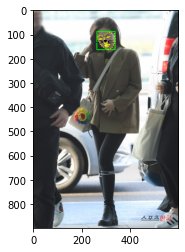

In [68]:
# 스티커에서 사용할 부분은 0이 아닌 색이 있는 부분 사용
# np.where통해 img_sticker가 0인 부분은 sticker_area를 사용
# 0이 아닌 부분을 img_sticker사용
img_show[refined_y:refined_y+ img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

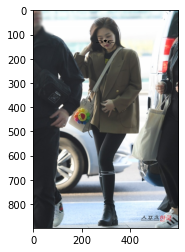

In [69]:
# bounding box와 landmark제거하고 최종 결과만 출력
# img_show 대신, img_rbg 활용
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점 찾아보기
- 다양한 각도에서 셀카 촬영, 반복 적용
- 문제점이 뭔지 최대한 자세히 기록
    -얼굴 각도에 따라 스티커가 어떻게 변해야할까요?  
    
    -멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    
    -실행 속도가 중요할까요?
    
    -스티커앱을 만들 때 정확도가 얼마나 중요할까요?


# 멀리서 촬영시

사실 멀리서 촬영한 사진을 구하기가 쉽지 않아서 어렵게 구한 사진으로 해보았는데, 내 생각에 멀리서 촬영한 사진을 쓰면 안되는 이유는 얼굴을 특정할 수가 없어서 인 것 같다. 멀리서 보면 눈코입이 어디있는 지도 제대로 파악을 못할 것으로 보인다.